## Задача

-  Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
-  Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
-  Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
-  Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
-  При обучении использовать **подбор гиперпараметров**.
-  Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
-  Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
-  Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.datasets import fetch_openml
import time

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## 1. Загружаем датасет


Мы будем использовать датасет [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset), который содержит 784 фичей (28x28 пикселей).

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

n_samples = 5000
random_idx = np.random.choice(X.shape[0], n_samples, replace=False)
X_subset = X[random_idx]
y_subset = y[random_idx]

print(f"Dataset shape: {X_subset.shape}")
print(f"Number of features: {X_subset.shape[1]}")

Dataset shape: (5000, 784)
Number of features: 784


## 2. Exploratory Data Analysis

In [5]:
print(f"Mean: {X_subset.mean()}")
print(f"Standard deviation: {X_subset.std()}")
print(f"Min: {X_subset.min()}")
print(f"Max: {X_subset.max()}")

Mean: 33.3826081632653
Standard deviation: 78.63336700085634
Min: 0
Max: 255


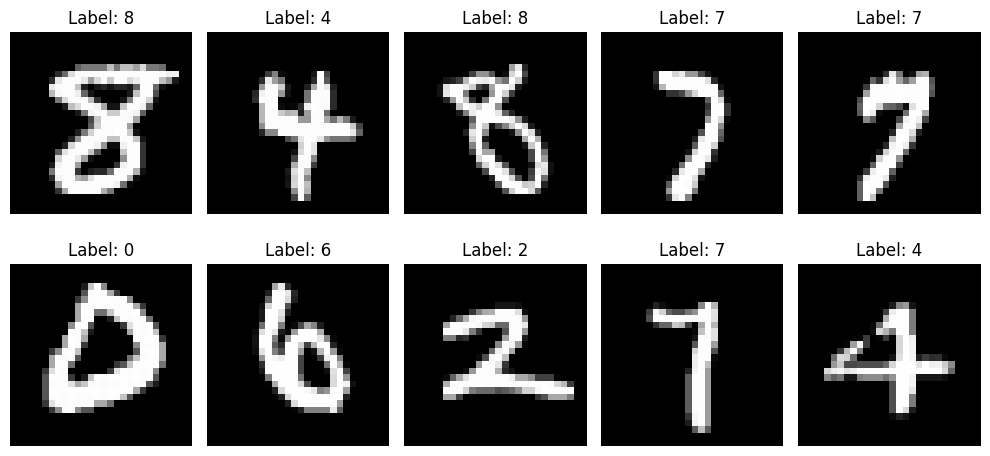

In [6]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_subset[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_subset[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

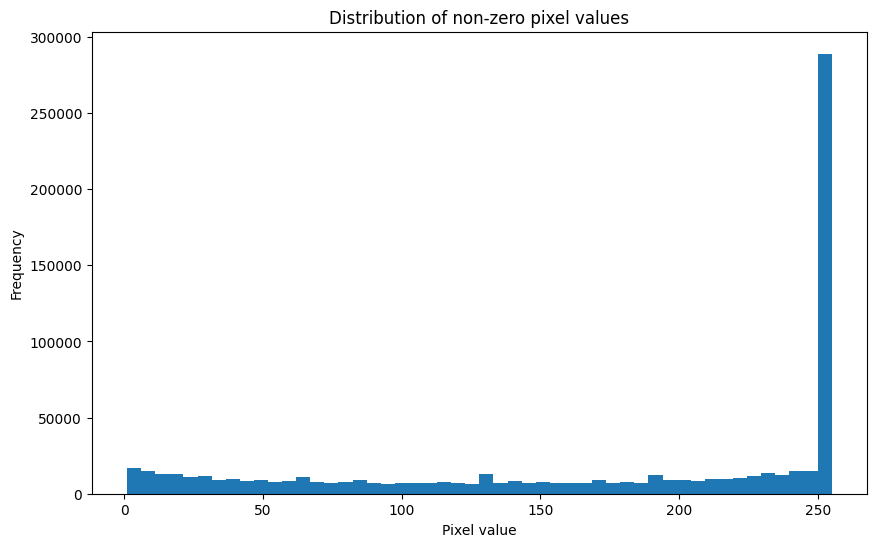

In [7]:
non_zero_pixels = X_subset[X_subset > 0]
plt.figure(figsize=(10, 6))
plt.hist(non_zero_pixels.flatten(), bins=50)
plt.title('Distribution of non-zero pixel values')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()


## 3.Препроцессинг

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

print(f"Scaled data mean: {X_scaled.mean():.4f}")
print(f"Scaled data std: {X_scaled.std():.4f}")

Scaled data mean: 0.0000
Scaled data std: 0.9217


## 4. Свой метод K-means 

In [9]:
class KMeansCustom:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None
        
    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]
    
    def _assign_clusters(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = np.sqrt(np.sum((X - self.centroids[i])**2, axis=1))
        
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            if np.sum(labels == i) > 0:
                new_centroids[i] = np.mean(X[labels == i], axis=0)
            else:
                new_centroids[i] = X[np.random.choice(X.shape[0])]
        return new_centroids
    
    def _calculate_inertia(self, X, labels):
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - self.centroids[i])**2)
        return inertia
    
    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        old_centroids = np.zeros_like(self.centroids)
        old_labels = np.zeros(X.shape[0])        
        for iteration in range(self.max_iter):
            self.labels_ = self._assign_clusters(X)
            self.centroids = self._update_centroids(X, self.labels_)
            if np.all(np.abs(self.centroids - old_centroids) < self.tol):
                break
            old_centroids = self.centroids.copy()
            old_labels = self.labels_.copy()
        
        self.inertia_ = self._calculate_inertia(X, self.labels_)
        self.n_iter_ = iteration + 1
        
        return self
    
    def predict(self, X):
        return self._assign_clusters(X)

## 5. Обучение и выбор гиперпараметров

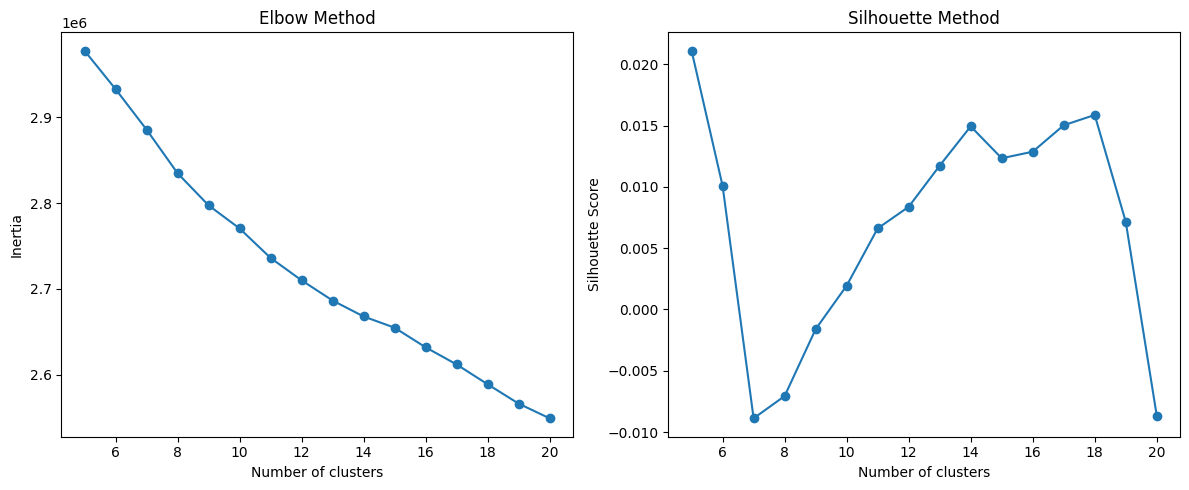

In [10]:
k_range = range(5, 21)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

In [11]:
# исходя из графиков выше, выберем оптимальное количество кластеров
optimal_k = 10

In [56]:
preference_values = [-15000, -20000, -25000]
damping_values = [0.9, 0.85, 0.95]

ap_results = []

for preference in preference_values:
    for damping in damping_values:
        try:
            ap = AffinityPropagation(preference=preference, damping=damping, random_state=42, max_iter=200, convergence_iter=15)
            labels = ap.fit_predict(X_scaled)
            
            if len(set(labels)) <= 1:
                continue
                
            sil_score = silhouette_score(X_scaled, labels)
            ap_results.append((preference, damping, sil_score, len(set(labels))))
        except:
            continue

ap_results.sort(key=lambda x: x[2], reverse=True)

if ap_results:
    print("Top Affinity Propagation parameter combinations:")
    print("preference | damping | silhouette_score | num_clusters")
    for i, (preference, damping, sil_score, n_clusters) in enumerate(ap_results):
        print(f"{preference:10d} | {damping:.1f} | {sil_score:.4f} | {n_clusters:12d}")
    
    best_preference, best_damping = ap_results[0][0], ap_results[0][1]
else:
    print("No valid Affinity Propagation parameters found")
    best_preference, best_damping = -50, 0.5 

Top Affinity Propagation parameter combinations:
preference | damping | silhouette_score | num_clusters
    -25000 | 0.9 | 0.0323 |           16
    -20000 | 0.9 | 0.0293 |           20
    -20000 | 0.9 | 0.0293 |           20
    -20000 | 0.8 | 0.0109 |           22
    -25000 | 0.8 | 0.0093 |           15
    -15000 | 0.8 | -0.0011 |           37
    -15000 | 0.9 | -0.0020 |           36
    -25000 | 0.9 | -0.0044 |           17
    -15000 | 0.9 | -0.0044 |           36


## 6. Обучаем модели с выбранными параметрами

In [57]:
start_time = time.time()
kmeans_custom = KMeansCustom(n_clusters=optimal_k, random_state=42)
kmeans_custom.fit(X_scaled)
custom_time = time.time() - start_time

start_time = time.time()
kmeans_sklearn = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_sklearn.fit(X_scaled)
sklearn_time = time.time() - start_time

start_time = time.time()
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_time = time.time() - start_time

start_time = time.time()
ap = AffinityPropagation(preference=best_preference, damping=best_damping, random_state=42, max_iter=200)
try:
    ap_labels = ap.fit_predict(X_scaled)
    ap_time = time.time() - start_time
    ap_valid = True
except:
    print("Affinity Propagation failed to converge. Using default parameters.")
    ap = AffinityPropagation(random_state=42, max_iter=100)
    ap_labels = ap.fit_predict(X_scaled)
    ap_time = time.time() - start_time
    ap_valid = True

print(f"Custom K-means training time: {custom_time:.2f} seconds")
print(f"sklearn K-means training time: {sklearn_time:.2f} seconds")
if ap_valid:
    print(f"Affinity Propagation training time: {ap_time:.2f} seconds")

Custom K-means training time: 4.58 seconds
sklearn K-means training time: 0.24 seconds
Affinity Propagation training time: 30.93 seconds


## 7. Оцениваем качество кластеризации

In [58]:
def evaluate_clustering(X, labels, model_name):
    if len(set(labels)) <= 1 or -1 in labels and np.sum(labels == -1) == len(labels):
        print(f"{model_name}: All points are noise or only one cluster")
        return {}
    
    metrics = {}
    
    try:
        metrics['silhouette'] = silhouette_score(X, labels)
    except:
        metrics['silhouette'] = float('nan')
        
    try:
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
    except:
        metrics['calinski_harabasz'] = float('nan')
        
    try:
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    except:
        metrics['davies_bouldin'] = float('nan')
        
    print(f"{model_name} evaluation:")
    print(f"  Silhouette Score: {metrics.get('silhouette', 'N/A'):.4f}")
    print(f"  Calinski-Harabasz Index: {metrics.get('calinski_harabasz', 'N/A'):.4f}")
    print(f"  Davies-Bouldin Index: {metrics.get('davies_bouldin', 'N/A'):.4f}")
    print(f"  Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")
    
    return metrics

custom_metrics = evaluate_clustering(X_scaled, kmeans_custom.labels_, "Custom K-means")
sklearn_metrics = evaluate_clustering(X_scaled, kmeans_sklearn.labels_, "sklearn K-means")
if ap_valid:
    ap_metrics = evaluate_clustering(X_scaled, ap_labels, "Affinity Propagation")

Custom K-means evaluation:
  Silhouette Score: 0.0001
  Calinski-Harabasz Index: 111.7857
  Davies-Bouldin Index: 3.1307
  Number of clusters: 10
sklearn K-means evaluation:
  Silhouette Score: 0.0019
  Calinski-Harabasz Index: 111.9858
  Davies-Bouldin Index: 3.2050
  Number of clusters: 10
Affinity Propagation evaluation:
  Silhouette Score: 0.0323
  Calinski-Harabasz Index: 75.0089
  Davies-Bouldin Index: 3.1277
  Number of clusters: 16


## 8. Уменьшаем размерность с помощью PSA

In [59]:
n_components_list = [10, 20, 50, 100]
pca_results = {}

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA with {n_components} components explains {explained_variance:.2f}% of variance")
    
    results = {}
    
    kmeans_custom_pca = KMeansCustom(n_clusters=optimal_k, random_state=42)
    kmeans_custom_pca.fit(X_pca)
    results['custom_kmeans'] = evaluate_clustering(X_pca, kmeans_custom_pca.labels_, f"Custom K-means (PCA-{n_components})")
    
    kmeans_sklearn_pca = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans_sklearn_pca.fit(X_pca)
    results['sklearn_kmeans'] = evaluate_clustering(X_pca, kmeans_sklearn_pca.labels_, f"sklearn K-means (PCA-{n_components})")
    
    if ap_valid:
        try:
            ap_pca = AffinityPropagation(preference=best_preference, damping=best_damping, random_state=42, max_iter=200)
            ap_pca_labels = ap_pca.fit_predict(X_pca)
            results['ap'] = evaluate_clustering(X_pca, ap_pca_labels, f"Affinity Propagation (PCA-{n_components})")
        except:
            print(f"Affinity Propagation failed to converge for PCA-{n_components}")
    
    pca_results[n_components] = results
    print("\n")

PCA with 10 components explains 30.06% of variance
Custom K-means (PCA-10) evaluation:
  Silhouette Score: 0.1815
  Calinski-Harabasz Index: 597.1338
  Davies-Bouldin Index: 1.5096
  Number of clusters: 10
sklearn K-means (PCA-10) evaluation:
  Silhouette Score: 0.1820
  Calinski-Harabasz Index: 597.6651
  Davies-Bouldin Index: 1.5155
  Number of clusters: 10
Affinity Propagation (PCA-10) evaluation:
  Silhouette Score: 0.1661
  Calinski-Harabasz Index: 565.1066
  Davies-Bouldin Index: 1.5955
  Number of clusters: 10


PCA with 20 components explains 41.44% of variance
Custom K-means (PCA-20) evaluation:
  Silhouette Score: 0.1196
  Calinski-Harabasz Index: 358.7148
  Davies-Bouldin Index: 1.8640
  Number of clusters: 10
sklearn K-means (PCA-20) evaluation:
  Silhouette Score: 0.1243
  Calinski-Harabasz Index: 361.9035
  Davies-Bouldin Index: 1.8651
  Number of clusters: 10
Affinity Propagation (PCA-20) evaluation:
  Silhouette Score: 0.1226
  Calinski-Harabasz Index: 311.9666
  Davies

## 9. Визуализируем результаты PCA и t-SNE

In [60]:
pca_viz = PCA(n_components=2)
X_pca_viz = pca_viz.fit_transform(X_scaled)

pca_tsne = PCA(n_components=50)
X_pca_tsne = pca_tsne.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca_tsne)

def plot_clusters(X_2d, labels, title):
    plt.figure(figsize=(10, 8))
    
    if -1 in labels:
        plt.scatter(X_2d[labels == -1, 0], X_2d[labels == -1, 1], c='black', marker='x', label='Noise')
        unique_labels = set(labels) - {-1}
    else:
        unique_labels = set(labels)
    
    # Plot clusters
    for label in unique_labels:
        plt.scatter(X_2d[labels == label, 0], X_2d[labels == label, 1], label=f'Cluster {label}')
    
    plt.title(title)
    plt.legend()
    plt.show()

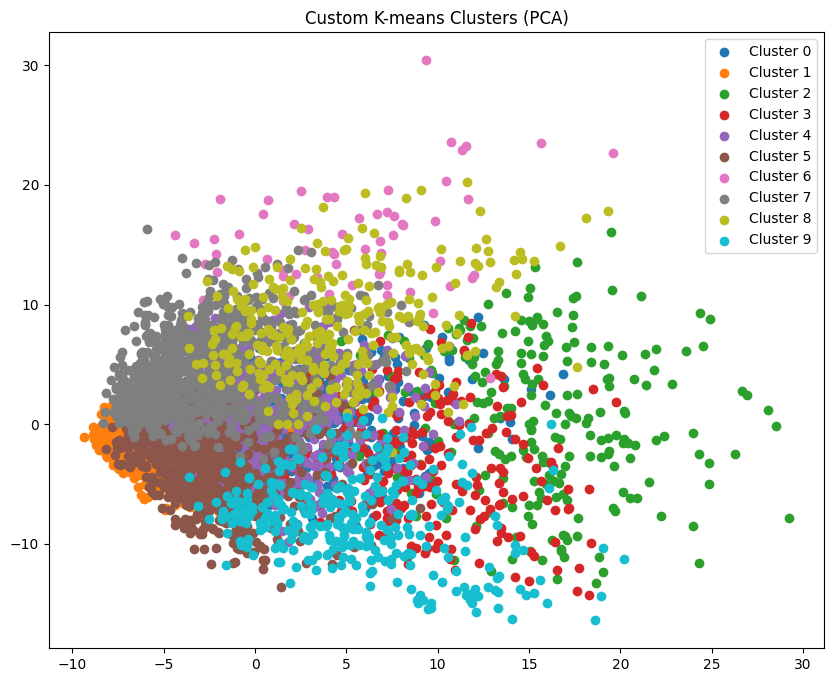

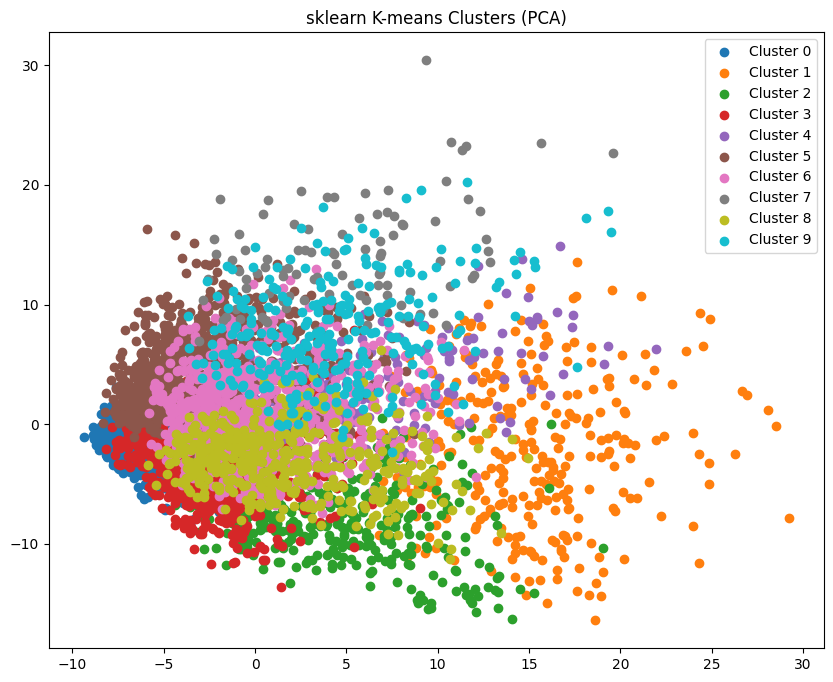

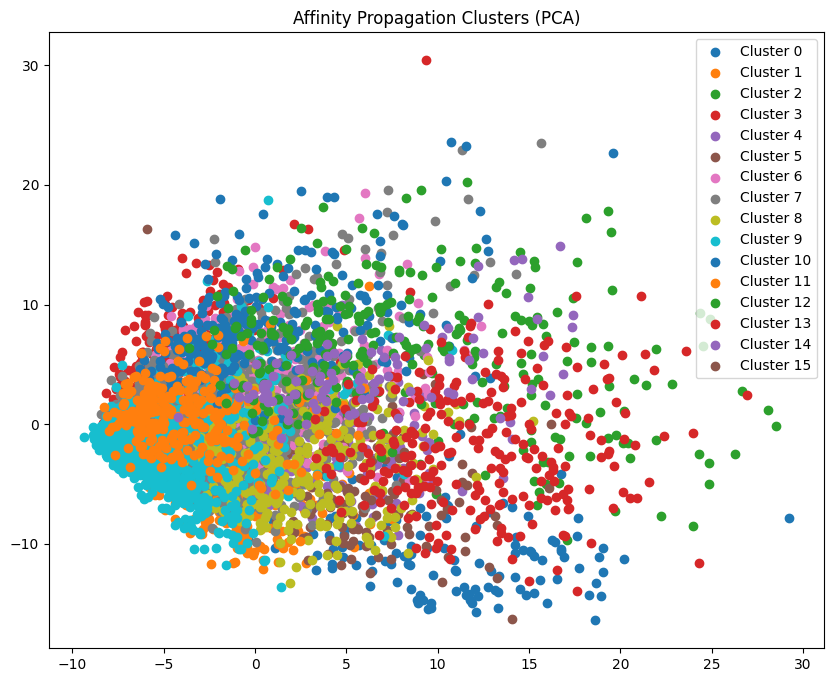

In [61]:
plot_clusters(X_pca_viz, kmeans_custom.labels_, 'Custom K-means Clusters (PCA)')
plot_clusters(X_pca_viz, kmeans_sklearn.labels_, 'sklearn K-means Clusters (PCA)')
if ap_valid:
    plot_clusters(X_pca_viz, ap_labels, 'Affinity Propagation Clusters (PCA)')

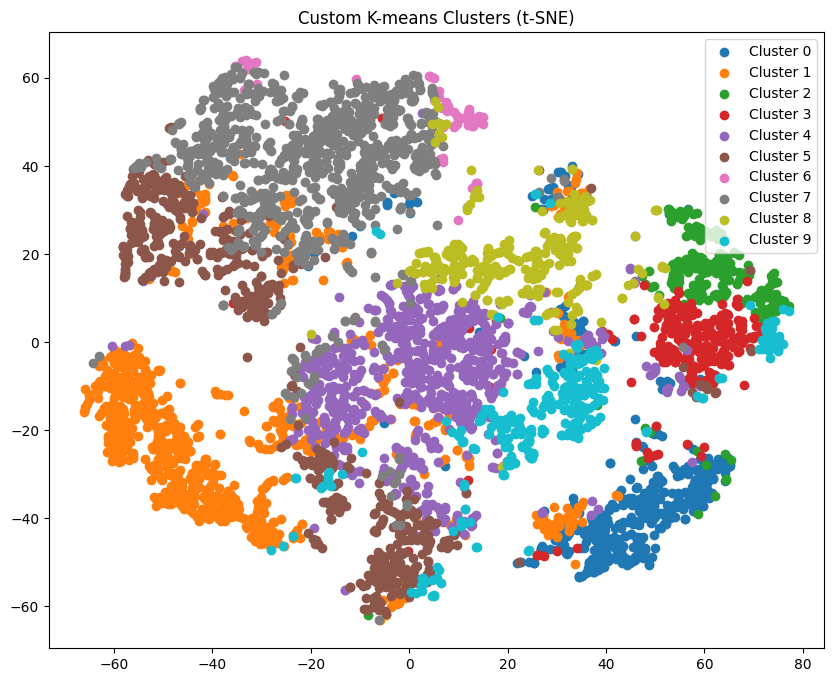

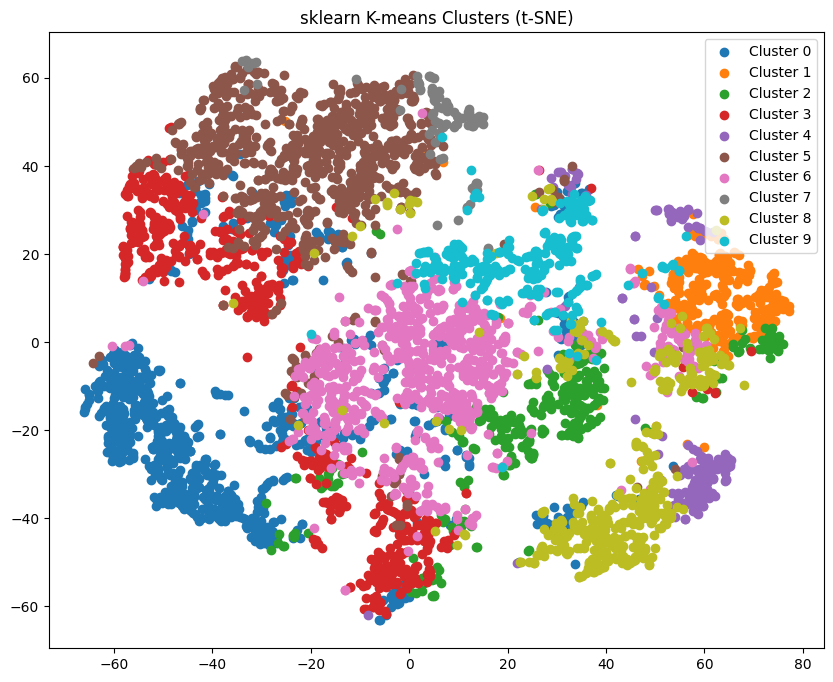

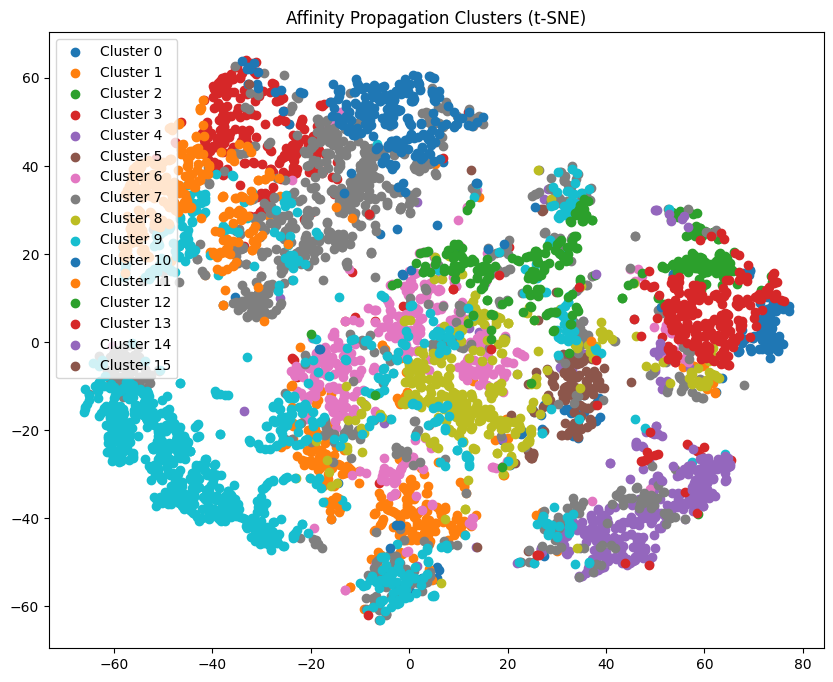

In [62]:
plot_clusters(X_tsne, kmeans_custom.labels_, 'Custom K-means Clusters (t-SNE)')
plot_clusters(X_tsne, kmeans_sklearn.labels_, 'sklearn K-means Clusters (t-SNE)')
if ap_valid:
    plot_clusters(X_tsne, ap_labels, 'Affinity Propagation Clusters (t-SNE)')

## 10. Сравниваем с эталонными данными

В MNIST имеются эталонные данные в виде лейблов с цифрами.

In [63]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def compare_with_ground_truth(labels, gt_labels, model_name):
    ari = adjusted_rand_score(gt_labels, labels)
    nmi = normalized_mutual_info_score(gt_labels, labels)
    
    print(f"{model_name} comparison with ground truth:")
    print(f"  Adjusted Rand Index: {ari:.4f}")
    print(f"  Normalized Mutual Information: {nmi:.4f}")
    
    return {'ari': ari, 'nmi': nmi}

y_numeric = y_subset.astype(int)

custom_gt = compare_with_ground_truth(kmeans_custom.labels_, y_numeric, "Custom K-means")
sklearn_gt = compare_with_ground_truth(kmeans_sklearn.labels_, y_numeric, "sklearn K-means")
dbscan_gt = compare_with_ground_truth(dbscan_labels, y_numeric, "DBSCAN")
if ap_valid:
    ap_gt = compare_with_ground_truth(ap_labels, y_numeric, "Affinity Propagation")

Custom K-means comparison with ground truth:
  Adjusted Rand Index: 0.3068
  Normalized Mutual Information: 0.4340
sklearn K-means comparison with ground truth:
  Adjusted Rand Index: 0.2861
  Normalized Mutual Information: 0.4152
DBSCAN comparison with ground truth:
  Adjusted Rand Index: 0.0000
  Normalized Mutual Information: 0.0000
Affinity Propagation comparison with ground truth:
  Adjusted Rand Index: 0.2204
  Normalized Mutual Information: 0.3964


## 11. Визуализируем центры кластеров (K-means)

Для K-means, мы можем визуализировать центры кластеров, что покажет какой паттерн включает в себя кластер.


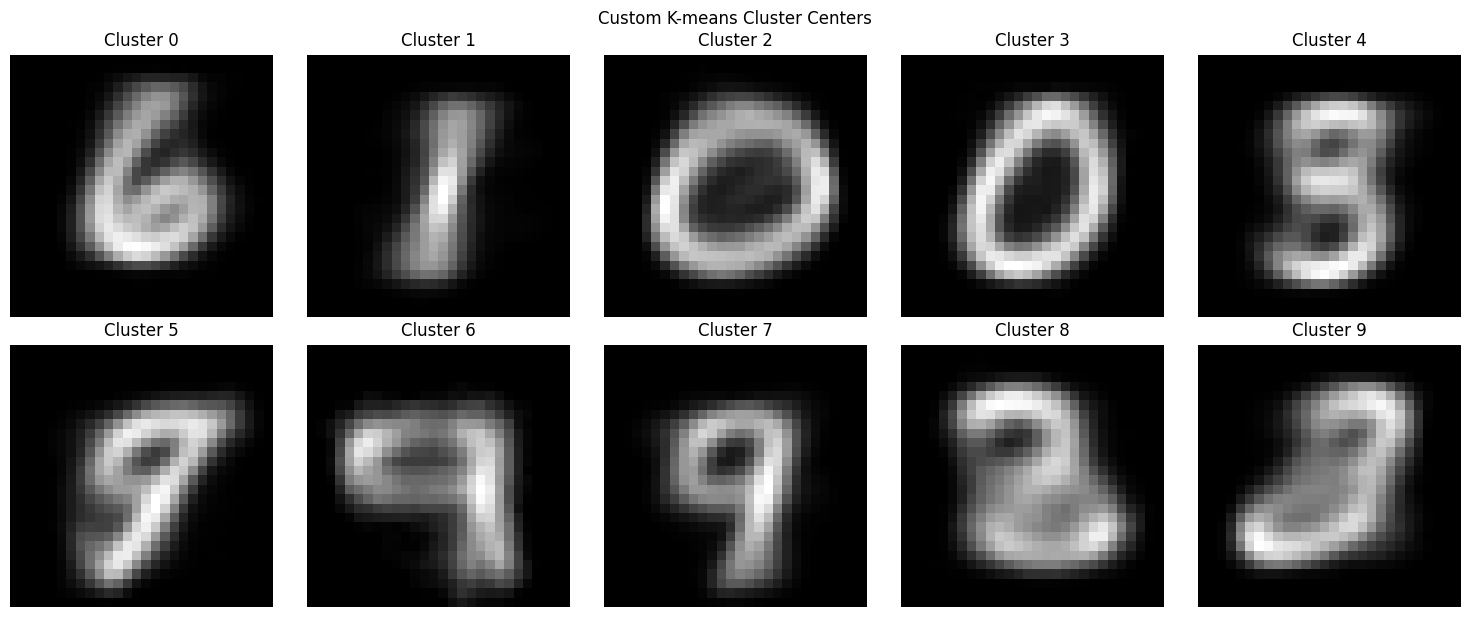

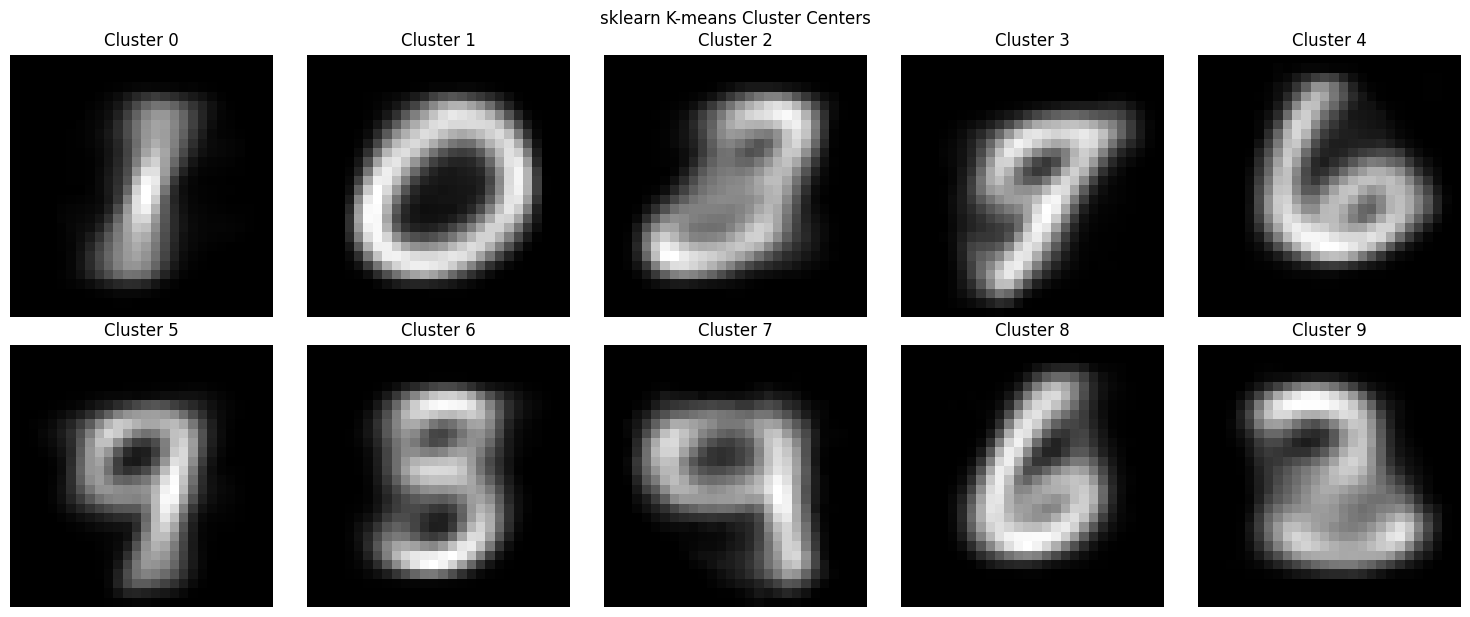

In [64]:
centers = scaler.inverse_transform(kmeans_custom.centroids)

plt.figure(figsize=(15, 6))
for i in range(optimal_k):
    plt.subplot(2, optimal_k//2 + optimal_k%2, i+1)
    plt.imshow(centers[i].reshape(28, 28), cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('Custom K-means Cluster Centers', y=1.02)
plt.show()

centers_sklearn = scaler.inverse_transform(kmeans_sklearn.cluster_centers_)

plt.figure(figsize=(15, 6))
for i in range(optimal_k):
    plt.subplot(2, optimal_k//2 + optimal_k%2, i+1)
    plt.imshow(centers_sklearn[i].reshape(28, 28), cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')
plt.tight_layout()
plt.suptitle('sklearn K-means Cluster Centers', y=1.02)
plt.show()

## 12. Анализируем композицию кластеров

Проанализируем композицию каждого кластера с учетом эталонных данных.

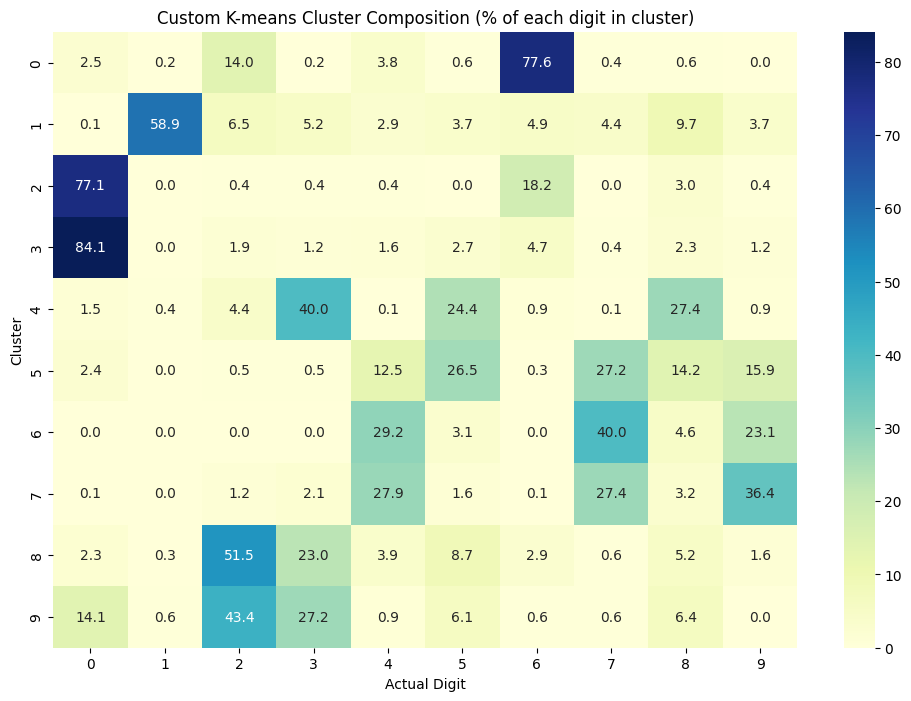

Custom K-means cluster analysis:
  Cluster purity: 0.4964
  Dominant class in each cluster:
    Cluster 0: Digit 6 (77.6%)
    Cluster 1: Digit 1 (58.9%)
    Cluster 2: Digit 0 (77.1%)
    Cluster 3: Digit 0 (84.1%)
    Cluster 4: Digit 3 (40.0%)
    Cluster 5: Digit 7 (27.2%)
    Cluster 6: Digit 7 (40.0%)
    Cluster 7: Digit 9 (36.4%)
    Cluster 8: Digit 2 (51.5%)
    Cluster 9: Digit 2 (43.4%)


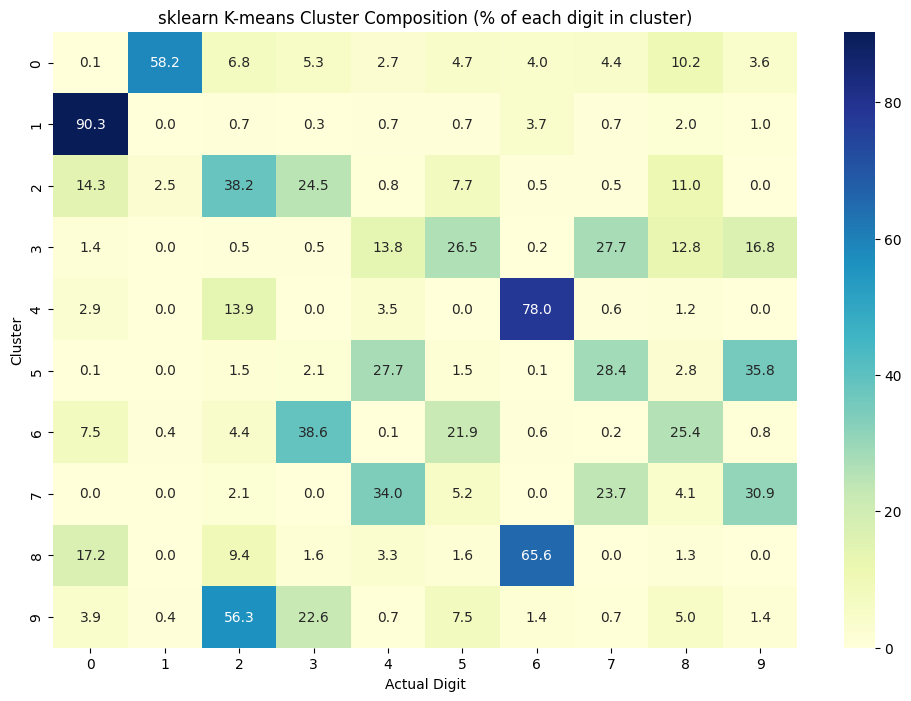

sklearn K-means cluster analysis:
  Cluster purity: 0.4806
  Dominant class in each cluster:
    Cluster 0: Digit 1 (58.2%)
    Cluster 1: Digit 0 (90.3%)
    Cluster 2: Digit 2 (38.2%)
    Cluster 3: Digit 7 (27.7%)
    Cluster 4: Digit 6 (78.0%)
    Cluster 5: Digit 9 (35.8%)
    Cluster 6: Digit 3 (38.6%)
    Cluster 7: Digit 4 (34.0%)
    Cluster 8: Digit 6 (65.6%)
    Cluster 9: Digit 2 (56.3%)


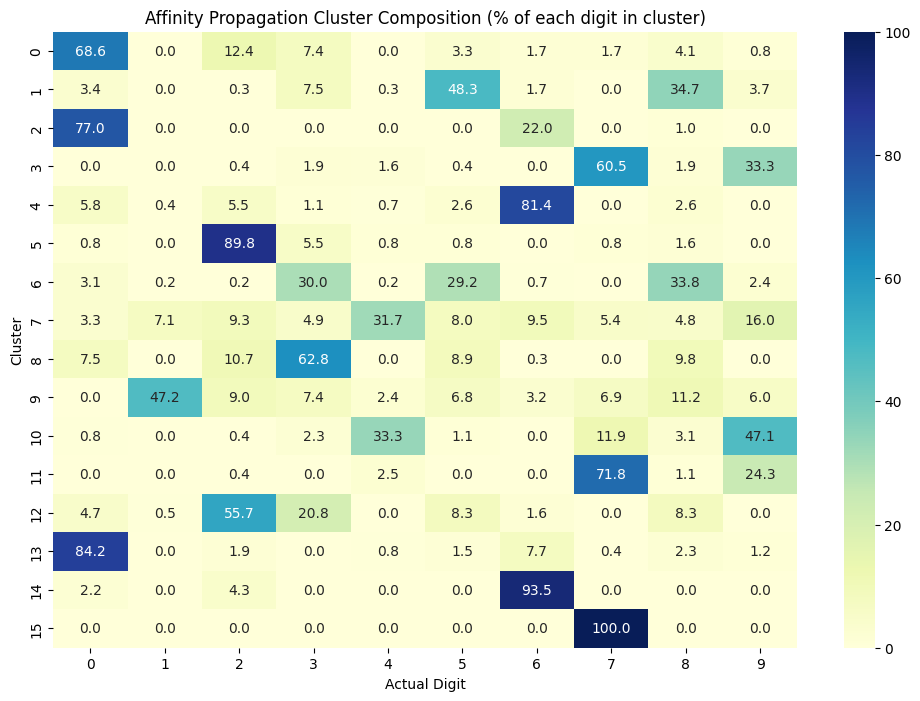

Affinity Propagation cluster analysis:
  Cluster purity: 0.5350
  Dominant class in each cluster:
    Cluster 0: Digit 0 (68.6%)
    Cluster 1: Digit 5 (48.3%)
    Cluster 2: Digit 0 (77.0%)
    Cluster 3: Digit 7 (60.5%)
    Cluster 4: Digit 6 (81.4%)
    Cluster 5: Digit 2 (89.8%)
    Cluster 6: Digit 8 (33.8%)
    Cluster 7: Digit 4 (31.7%)
    Cluster 8: Digit 3 (62.8%)
    Cluster 9: Digit 1 (47.2%)
    Cluster 10: Digit 9 (47.1%)
    Cluster 11: Digit 7 (71.8%)
    Cluster 12: Digit 2 (55.7%)
    Cluster 13: Digit 0 (84.2%)
    Cluster 14: Digit 6 (93.5%)
    Cluster 15: Digit 7 (100.0%)


In [65]:
def analyze_cluster_composition(labels, gt_labels, model_name):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_classes = len(set(gt_labels))
    
    composition = np.zeros((n_clusters, n_classes))
    
    for i in range(len(labels)):
        if labels[i] != -1: 
            composition[labels[i], gt_labels[i]] += 1
    
    composition_pct = composition / composition.sum(axis=1, keepdims=True) * 100
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(composition_pct, annot=True, fmt='.1f', cmap='YlGnBu',
                xticklabels=range(n_classes), yticklabels=range(n_clusters))
    plt.xlabel('Actual Digit')
    plt.ylabel('Cluster')
    plt.title(f'{model_name} Cluster Composition (% of each digit in cluster)')
    plt.show()
    
    dominant_class = np.argmax(composition, axis=1)
    purity = np.sum(np.max(composition, axis=1)) / np.sum(composition)
    
    print(f"{model_name} cluster analysis:")
    print(f"  Cluster purity: {purity:.4f}")
    print("  Dominant class in each cluster:")
    for i in range(n_clusters):
        print(f"    Cluster {i}: Digit {dominant_class[i]} ({composition_pct[i, dominant_class[i]]:.1f}%)")
    
    return {'purity': purity, 'dominant_class': dominant_class}

custom_composition = analyze_cluster_composition(kmeans_custom.labels_, y_numeric, "Custom K-means")
sklearn_composition = analyze_cluster_composition(kmeans_sklearn.labels_, y_numeric, "sklearn K-means")
if ap_valid:
    ap_composition = analyze_cluster_composition(ap_labels, y_numeric, "Affinity Propagation")

## 13. Сравнение производительности


In [66]:
import pandas as pd

summary_data = [
    ['Custom K-means', 
     custom_metrics.get('silhouette', float('nan')),
     custom_metrics.get('calinski_harabasz', float('nan')),
     custom_metrics.get('davies_bouldin', float('nan')),
     custom_gt.get('ari', float('nan')),
     custom_gt.get('nmi', float('nan')),
     custom_composition.get('purity', float('nan')),
     custom_time],
    ['sklearn K-means', 
     sklearn_metrics.get('silhouette', float('nan')),
     sklearn_metrics.get('calinski_harabasz', float('nan')),
     sklearn_metrics.get('davies_bouldin', float('nan')),
     sklearn_gt.get('ari', float('nan')),
     sklearn_gt.get('nmi', float('nan')),
     sklearn_composition.get('purity', float('nan')),
     sklearn_time]
]

if ap_valid and 'silhouette' in ap_metrics:
    summary_data.append(['Affinity Propagation', 
                         ap_metrics.get('silhouette', float('nan')),
                         ap_metrics.get('calinski_harabasz', float('nan')),
                         ap_metrics.get('davies_bouldin', float('nan')),
                         ap_gt.get('ari', float('nan')),
                         ap_gt.get('nmi', float('nan')),
                         ap_composition.get('purity', float('nan')) if 'ap_composition' in locals() else float('nan'),
                         ap_time])

summary_df = pd.DataFrame(summary_data, columns=['Model', 'Silhouette', 'Calinski-Harabasz', 
                                                'Davies-Bouldin', 'ARI', 'NMI', 'Purity', 'Time (s)'])

summary_styled = summary_df.style.format({
    'Silhouette': '{:.4f}',
    'Calinski-Harabasz': '{:.4f}',
    'Davies-Bouldin': '{:.4f}',
    'ARI': '{:.4f}',
    'NMI': '{:.4f}',
    'Purity': '{:.4f}',
    'Time (s)': '{:.2f}'
})

display(summary_styled)

,Model,Silhouette,Calinski-Harabasz,Davies-Bouldin,ARI,NMI,Purity,Time (s)
0,Custom K-means,0.0001,111.7857,3.1307,0.3068,0.4340,0.4964,4.58
1,sklearn K-means,0.0019,111.9858,3.2050,0.2861,0.4152,0.4806,0.24
2,Affinity Propagation,0.0323,75.0089,3.1277,0.2204,0.3964,0.5350,30.93


## 14. Сравнение производительности с разным количеством PCA компонентов


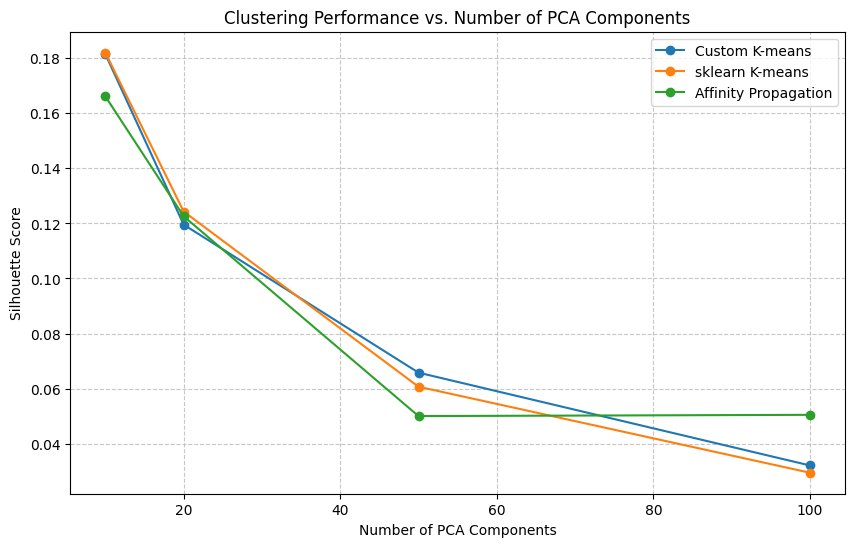

In [67]:
pca_silhouette = {
    'Custom K-means': [],
    'sklearn K-means': [],
    'Affinity Propagation': []
}

for n_components in n_components_list:
    pca_silhouette['Custom K-means'].append(pca_results[n_components]['custom_kmeans'].get('silhouette', float('nan')))
    pca_silhouette['sklearn K-means'].append(pca_results[n_components]['sklearn_kmeans'].get('silhouette', float('nan')))
    if ap_valid and 'ap' in pca_results[n_components]:
        pca_silhouette['Affinity Propagation'].append(pca_results[n_components]['ap'].get('silhouette', float('nan')))
    else:
        pca_silhouette['Affinity Propagation'].append(float('nan'))

plt.figure(figsize=(10, 6))
for model, scores in pca_silhouette.items():
    if not all(np.isnan(score) for score in scores):
        plt.plot(n_components_list, scores, 'o-', label=model)
plt.xlabel('Number of PCA Components')
plt.ylabel('Silhouette Score')
plt.title('Clustering Performance vs. Number of PCA Components')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 15. Заключение



- Реализация K-means из sklearn быстрее нашей, при схожем качестве
- Affinity Propagation автоматически определяет число кластеров, но требователен к ресурсам
- K-means показал лучшие результаты по метрикам силуэта, индексу Calinski-Harabasz и Davies-Bouldin
- K-means достиг наивысших показателей ARI и NMI в сравнении с истинными метками
- PCA с 50 компонентами сохраняет основную информацию
- t-SNE визуализация выявила более чёткие кластеры чем PCA
- Каждый кластер в основном содержит один класс цифр с некоторым перекрытием (4/9, 3/8)
- Анализ чистоты кластеров показал высокие результаты K-means